Ref
- https://towardsdatascience.com/object-detection-in-6-steps-using-detectron2-705b92575578
- https://github.com/aakarsh7599/Text-Detection-using-Detectron2/blob/master/Inference_from_saved_model_Detectron2.ipynb

## Install Detectron2

And dependencies...

In [ ]:
# !pip install pyyaml==5.1

# import torch
# TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
# CUDA_VERSION = torch.__version__.split("+")[-1]
# print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# # Install detectron2 that matches the above pytorch version
# # See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# # If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# #exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

In [ ]:
# Detectron2
!pip install torch==1.10.1+cu111 torchvision==0.11.2+cu111 torchaudio==0.10.1 -f https://download.pytorch.org/whl/torch_stable.html
!pip install pyyaml==5.1  > /dev/null
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow #, cv2_imwrite

# Import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Download Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Get face detection dataset
#!unzip /content/drive/MyDrive/machine_learning/datasets/CartoonDataset.zip > /dev/null
#!unzip /content/drive/MyDrive/machine_learning/datasets/disney_test_set.zip > /dev/null
#!unzip /content/drive/MyDrive/machine_learning/datasets/disney_test_3D.zip > /dev/null
#!unzip /content/drive/MyDrive/machine_learning/datasets/disney_3D_human_test.zip > /dev/null
!unzip /content/drive/MyDrive/machine_learning/datasets/Detection_Test.zip > /dev/null

In [ ]:
# Get face detection model
#!unzip /content/drive/MyDrive/machine_learning/Models/Detection/output_resnet50_50k_4epochs_noaugs_inMeanStdDev_blr0.0004_step6600.zip -d resnet50 > /dev/null
#!unzip /content/drive/MyDrive/machine_learning/Models/Detection/resnet101.zip -d resnet101 > /dev/null
#!unzip /content/drive/MyDrive/machine_learning/Models/Detection/ResNet101/010.zip -d resnet101 > /dev/null
#!unzip /content/drive/MyDrive/machine_learning/Models/Detection/ResNet52/006.zip -d resnet52 > /dev/null
#!unzip /content/drive/MyDrive/machine_learning/Models/Detection/ResNet50/007.zip -d resnet50 > /dev/null
!unzip /content/drive/MyDrive/machine_learning/Models/Face_Detection/ResNet101/016.zip > /dev/null

In [ ]:
# Get gender detection dataset
!unzip /content/drive/MyDrive/machine_learning/datasets/personai_icartoonface_rectrain.zip > /dev/null
!unzip /content/drive/MyDrive/machine_learning/datasets/icartoonface_rectrain.zip > /dev/null
# !unzip /content/drive/MyDrive/machine_learning/datasets/disney_2000-present.zip > /dev/null

In [ ]:
# Replace the annotation files with the desired ones
!cp /content/drive/MyDrive/machine_learning/datasets/icartoonface_rectrain_annotations/instances_train_usable10AndAllUsableWestern.json ./icartoonface_rectrain/annotations/instances_train.json > /dev/null
!cp /content/drive/MyDrive/machine_learning/datasets/icartoonface_rectrain_annotations/instances_val_usable10AndAllUsableWestern.json ./icartoonface_rectrain/annotations/instances_val.json > /dev/null

In [ ]:
# Get gender detection model
#!unzip /content/drive/MyDrive/machine_learning/Models/Gender_Detection/Archive/output_classification_3.zip > /dev/null # baseline trained on 5000
#!unzip /content/drive/MyDrive/machine_learning/Models/Gender_Detection/Archive/output_classification_4.zip > /dev/null # baseline trained on 40.000
#!unzip /content/drive/MyDrive/machine_learning/Models/Gender_Detection/Archive/output_classification_9.zip > /dev/null # otherless trained on 5000
#!unzip /content/drive/MyDrive/machine_learning/Models/Gender_Detection/Archive/output_classification_14.zip > /dev/null # usable (including otherless) trained on 5000
#!unzip /content/drive/MyDrive/machine_learning/Models/Gender_Detection/Archive/output_classification_16.zip > /dev/null # usable (including otherless) trained on 40.000
#!unzip /content/drive/MyDrive/machine_learning/Models/Gender_Detection/Archive/output_classification_18.zip > /dev/null # western trained on 20.000
#!unzip /content/drive/MyDrive/machine_learning/Models/Gender_Detection/Archive/output_classification_20.zip > /dev/null # usable + western trained on 40.000
!unzip /content/drive/MyDrive/machine_learning/Models/Gender_Detection/ResNet50/002.zip > /dev/null # trained on 3D_train

## Register Dataset



The function name "get_board_dicts" must remain unchanged! Since the functions take slightly different arguments, if all cells are run (e.g. dettrain and disney registration), later on the model might complain that it's not receiving the correct arguments because it's using the most recent, possibly wrong, "get_board_dicts" function

In [ ]:
# Register dettrain val set
import json
from detectron2.structures import BoxMode

def get_board_dicts(imgdir):
    json_file = f"{imgdir}/datasets.json"
    with open(json_file) as f:
        dataset_dicts = json.load(f)
    for i in dataset_dicts:
        filename = i["file_name"]   
        i["file_name"] = f"{imgdir}/{filename}" 
        for j in i["annotations"]:
            j["bbox_mode"] = BoxMode.XYWH_ABS
            j["category_id"] = int(j["category_id"])
    return dataset_dicts

from detectron2.data import DatasetCatalog, MetadataCatalog
def register_datasets():
    for d in ["val"]:
        DatasetCatalog.register(f"cartoon_{d}", lambda d=d: get_board_dicts(f"./CartoonDataset/{d}"))
        MetadataCatalog.get(f"cartoon_{d}").set(thing_classes=["Face"]) # ["Face"] or ["Female", "Male", "Other"] if want to see localization accuracy of gender detector
    return
  
register_datasets()

In [ ]:
# Register disney 3D human test set
test_name = "..."

def get_board_dicts(dir):
    import json
    from detectron2.structures import BoxMode
    import math
    import random

    # Load the instances
    dataset_dicts = detectron2.data.datasets.load_coco_json(f"{dir}/{test_name}_annots.json", dir, test_name)
    for i in dataset_dicts:
        for j in i["annotations"]:
            j["bbox"] = list(map(int, j["bbox"]))
            j["category_id"] = 0 # 0 to set everything to "Face"
    return dataset_dicts

def register_datasets():
    from detectron2.data import DatasetCatalog, MetadataCatalog

    for d in ["test"]:
      DatasetCatalog.register(test_name, lambda d=d: get_board_dicts(f"./{test_name}")) 
      MetadataCatalog.get(test_name).set(thing_classes=["Face"]) # just "face" if detection; "female", "male", ("other") if classification
      return
  
register_datasets()

In [ ]:
# Register dataset without annotations
import cv2
from detectron2.structures import BoxMode
import glob as gb
import pandas as pd
import os
import json

DATASET_PATH = "/content/2d_train"

for d in ["inference"]:
  # Initialise dataframe for storing the output json
  output = pd.DataFrame(columns=["file_name","height","width","annotations"])
  output["annotations"] = output["annotations"].astype('object')

  # loop through files
  fnames = [os.path.basename(f) for f in gb.glob(f"{DATASET_PATH}/*.jpg")]
  for fname in fnames:
    # load image if don't know dimensions
    dims = cv2.imread(f"{DATASET_PATH}/{fname}").shape[:2]

    # annotations
    temp = pd.DataFrame()
    temp["x1"] = 0
    temp["y1"] = 0
    temp["height"] = 0
    temp["width"] = 0
    temp["bbox"] = temp[["x1","y1","width","height"]].values.tolist()
    temp["bbox_mode"] = BoxMode.XYWH_ABS
    temp["category_id"] = 0
    temp = temp[["bbox",	"bbox_mode",	"category_id"]]
    annotations = temp.T.to_dict().values()
    l = []
    for j in annotations:
      l.append(j)

    # Entry for individual image and append to result
    res = pd.DataFrame(columns=["file_name","height","width","annotations"])
    res.at[0,"file_name"] = fname
    res.at[0,"height"] = dims[0]
    res.at[0,"width"] = dims[1]
    res["annotations"] = res["annotations"].astype('object')
    res.at[0,"annotations"] = l

    output = output.append(res)
    output.reset_index(drop=True,inplace=True)

  output.reset_index(inplace=True)
  output.rename(columns={"index": "image_id"}, inplace=True)
  output.to_json(f"{DATASET_PATH}/instances.json", orient="records")


def get_board_dicts(dir):
    # Load the instances
    json_file = f"{dir}/instances.json"
    with open(json_file) as f:
        dataset_dicts = json.load(f)
    for i in dataset_dicts:
      fname = i["file_name"]
      i["file_name"] = f"{DATASET_PATH}/{fname}"
      # for j in i["annotations"]:
      #     j["bbox_mode"] = BoxMode.XYWH_ABS
      #     j["category_id"] = int(0)
      #     j["bbox"] = list(map(int, j["bbox"])) #something wrong here?
    return dataset_dicts


def register_datasets():
    from detectron2.data import DatasetCatalog, MetadataCatalog

    for d in ["inference"]:
      DatasetCatalog.register("inference", lambda d=d: get_board_dicts(f"{DATASET_PATH}")) 
      MetadataCatalog.get("inference").set(thing_classes=["Face"]) # just "Face" if detection
      return
  

register_datasets()

In [ ]:
# # Register other disney test set
# test_name = "disney_2000-present"

# def get_board_dicts(annotsdir, d):
#     import json

#     json_file = f"{annotsdir}/instances_{d}.json"
#     with open(json_file) as f:
#         dataset_dicts = json.load(f)
    
#     for i in dataset_dicts:
#       fname = i["file_name"]
#       str_arr = fname.split("/")
#       new_name = f"{str_arr[1]}/{str_arr[2]}/{str_arr[3]}"
#       i["file_name"] = new_name

#     if d == "train":
#         return dataset_dicts
#     elif d == "val":
#         return dataset_dicts
#     else:
#         raise ValueError("Incorrect argument passed to function: get_board_dicts")

# def register_datasets():
#     from detectron2.data import DatasetCatalog, MetadataCatalog

#     for d in ["train", "val"]:
#         DatasetCatalog.register("cartoon_" + d, lambda d=d: get_board_dicts(f"{test_name}/annotations", d)) 
#         MetadataCatalog.get("cartoon_" + d).set(thing_classes=["female", "male"])
#     return

# register_datasets()

In [ ]:
# Register Detection_Test (upload .json from pc)
import json
from detectron2.structures import BoxMode

test_name = "Detection_Test"

def get_board_dicts(imgdir):
    json_file = f"{imgdir}/instances.json"
    with open(json_file) as f:
        dataset_dicts = json.load(f)
    for i in dataset_dicts:
        filename = i["file_name"].split("/")[-1] 
        i["file_name"] = f"{imgdir}/{filename}" 
        for j in i["annotations"]:
            j["bbox_mode"] = BoxMode.XYWH_ABS
            gender = j["attributes"]["gender"]
            j["category_id"] = 0 if gender == "female" else (1 if gender == "male" else 2) # 0 to just test facial detection
    return dataset_dicts

from detectron2.data import DatasetCatalog, MetadataCatalog
def register_datasets():
  for d in ["test"]:
    DatasetCatalog.register(test_name, lambda d=d: get_board_dicts(f"./{test_name}"))
    MetadataCatalog.get(test_name).set(thing_classes=["Female", "Male", "Other"]) # ["Face"] to just test facial detection
  return
  
register_datasets()

In [ ]:
# Register classification dataset
def get_board_dicts(annotsdir, d, size):
    import json
    from detectron2.structures import BoxMode
    import math
    import random

    if size != "all":
        size = int(size)

    json_file = annotsdir + f"/instances_{d}.json" 
    if size == "all":
        with open(json_file) as f:
            dataset_dicts = json.load(f)
        # dataset_dicts = [i for i in dataset_dicts if int(i["annotations"][0]["category_id"]) != 2] # filter out "Other"
        random.Random(42).shuffle(dataset_dicts) # seed 42
    else:
        if d == "train":
            with open(json_file) as f:
                dataset_dicts = json.load(f)
            # dataset_dicts = [i for i in dataset_dicts if int(i["annotations"][0]["category_id"]) != 2] # filter out "Other"
            dict_len = len(dataset_dicts)
            random.Random(42).shuffle(dataset_dicts) # seed 42
            dataset_dicts = dataset_dicts[:size]
            print(f"Shuffling {size} items from train ({dict_len})")
        elif d == "val":
            with open(json_file) as f:
                dataset_dicts = json.load(f)
            # dataset_dicts = [i for i in dataset_dicts if int(i["annotations"][0]["category_id"]) != 2] # filter out "Other"
            dict_len = len(dataset_dicts)
            val_size = math.ceil(size/10)
            random.Random(42).shuffle(dataset_dicts) # seed 42
            dataset_dicts = dataset_dicts[:val_size]
            print(f"Shuffling {val_size} items from val ({dict_len})")
        else:
            raise ValueError("Incorrect argument passed to function: get_board_dicts")

    for i in dataset_dicts:
        filename = i["file_name"]
        for j in i["annotations"]:
            j["bbox_mode"] = BoxMode.XYWH_ABS
            j["category_id"] = int(j["category_id"]) # set 0 for "Face"
        cat_id = int(i["annotations"][0]["category_id"])
        gender = "female" if cat_id == 0 else "male" if cat_id == 1 else "other" 
        # i["file_name"] = f"./icartoonface_rectrain/{d}/{gender}/{filename}"
        i["file_name"] = f"./personai_icartoonface_rectrain/icartoonface_rectrain/{filename}" # use with personai_icartoonface_rectrain
    if d == "train":
        return dataset_dicts
    elif d == "val":
        return dataset_dicts
    else:
        raise ValueError("Incorrect argument passed to function: get_board_dicts")

def register_datasets(size):
    from detectron2.data import DatasetCatalog, MetadataCatalog

    for d in ["train", "val"]:
        DatasetCatalog.register(f"cartoon_{d}", lambda d=d: get_board_dicts("icartoonface_rectrain/annotations", d, size)) 
        MetadataCatalog.get(f"cartoon_{d}").set(thing_classes=["Female", "Male", "Other"]) # ["Face"] or ["Female", "Male", sometimes removed "Other"]
    return
  
register_datasets("all")

In [ ]:
# Get length of training and val set, as well as class distribution
dataset_dicts_train = detectron2.data.get_detection_dataset_dicts("cartoon_train")
dataset_dicts_val = detectron2.data.get_detection_dataset_dicts("cartoon_val")
print(len(dataset_dicts_train), len(dataset_dicts_val))

### Register ResNet52

In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates.
import math
import numpy as np
import fvcore.nn.weight_init as weight_init
import torch
import torch.nn.functional as F
from torch import nn

from detectron2.layers import (
    CNNBlockBase,
    Conv2d,
    DeformConv,
    ModulatedDeformConv,
    ShapeSpec,
    get_norm,
)

from detectron2.modeling.backbone import Backbone
from detectron2.modeling.backbone.build import BACKBONE_REGISTRY

__all__ = [
    "ResNetBlockBase",
    "BasicBlock",
    "BottleneckBlock",
    "DeformBottleneckBlock",
    "BasicStem",
    "ResNet52", #MA
    "make_stage",
    "build_resnet_backbone",
    "build_resnet_fpn_backbone", #MA
    "FPN", #MA
]

####################
###### RESNET ######
####################

class BasicBlock(CNNBlockBase):
    """
    The basic residual block for ResNet-18 and ResNet-34 defined in :paper:`ResNet`,
    with two 3x3 conv layers and a projection shortcut if needed.
    """

    def __init__(self, in_channels, out_channels, *, stride=1, norm="BN"):
        """
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            stride (int): Stride for the first conv.
            norm (str or callable): normalization for all conv layers.
                See :func:`layers.get_norm` for supported format.
        """
        super().__init__(in_channels, out_channels, stride)

        if in_channels != out_channels:
            self.shortcut = Conv2d(
                in_channels,
                out_channels,
                kernel_size=1,
                stride=stride,
                bias=False,
                norm=get_norm(norm, out_channels),
            )
        else:
            self.shortcut = None

        self.conv1 = Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
            norm=get_norm(norm, out_channels),
        )

        self.conv2 = Conv2d(
            out_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
            norm=get_norm(norm, out_channels),
        )

        for layer in [self.conv1, self.conv2, self.shortcut]:
            if layer is not None:  # shortcut can be None
                weight_init.c2_msra_fill(layer)

    def forward(self, x):
        out = self.conv1(x)
        out = F.relu_(out)
        out = self.conv2(out)

        if self.shortcut is not None:
            shortcut = self.shortcut(x)
        else:
            shortcut = x

        out += shortcut
        out = F.relu_(out)
        return out


class BottleneckBlock(CNNBlockBase):
    """
    The standard bottleneck residual block used by ResNet-50, 101 and 152
    defined in :paper:`ResNet`.  It contains 3 conv layers with kernels
    1x1, 3x3, 1x1, and a projection shortcut if needed.
    """

    def __init__(
        self,
        in_channels,
        out_channels,
        *,
        bottleneck_channels,
        stride=1,
        num_groups=1,
        norm="BN",
        stride_in_1x1=False,
        dilation=1,
    ):
        """
        Args:
            bottleneck_channels (int): number of output channels for the 3x3
                "bottleneck" conv layers.
            num_groups (int): number of groups for the 3x3 conv layer.
            norm (str or callable): normalization for all conv layers.
                See :func:`layers.get_norm` for supported format.
            stride_in_1x1 (bool): when stride>1, whether to put stride in the
                first 1x1 convolution or the bottleneck 3x3 convolution.
            dilation (int): the dilation rate of the 3x3 conv layer.
        """
        super().__init__(in_channels, out_channels, stride)

        if in_channels != out_channels:
            self.shortcut = Conv2d(
                in_channels,
                out_channels,
                kernel_size=1,
                stride=stride,
                bias=False,
                norm=get_norm(norm, out_channels),
            )
        else:
            self.shortcut = None

        # The original MSRA ResNet models have stride in the first 1x1 conv
        # The subsequent fb.torch.resnet and Caffe2 ResNe[X]t implementations have
        # stride in the 3x3 conv
        stride_1x1, stride_3x3 = (stride, 1) if stride_in_1x1 else (1, stride)

        self.conv1 = Conv2d(
            in_channels,
            bottleneck_channels,
            kernel_size=1,
            stride=stride_1x1,
            bias=False,
            norm=get_norm(norm, bottleneck_channels),
        )

        self.conv2 = Conv2d(
            bottleneck_channels,
            bottleneck_channels,
            kernel_size=3,
            stride=stride_3x3,
            padding=1 * dilation,
            bias=False,
            groups=num_groups,
            dilation=dilation,
            norm=get_norm(norm, bottleneck_channels),
        )

        self.conv3 = Conv2d(
            bottleneck_channels,
            out_channels,
            kernel_size=1,
            bias=False,
            norm=get_norm(norm, out_channels),
        )

        for layer in [self.conv1, self.conv2, self.conv3, self.shortcut]:
            if layer is not None:  # shortcut can be None
                weight_init.c2_msra_fill(layer)

        # Zero-initialize the last normalization in each residual branch,
        # so that at the beginning, the residual branch starts with zeros,
        # and each residual block behaves like an identity.
        # See Sec 5.1 in "Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour":
        # "For BN layers, the learnable scaling coefficient γ is initialized
        # to be 1, except for each residual block's last BN
        # where γ is initialized to be 0."

        # nn.init.constant_(self.conv3.norm.weight, 0)
        # TODO this somehow hurts performance when training GN models from scratch.
        # Add it as an option when we need to use this code to train a backbone.

    def forward(self, x):
        out = self.conv1(x)
        out = F.relu_(out)

        out = self.conv2(out)
        out = F.relu_(out)

        out = self.conv3(out)

        if self.shortcut is not None:
            shortcut = self.shortcut(x)
        else:
            shortcut = x

        out += shortcut
        out = F.relu_(out)
        return out


class DeformBottleneckBlock(CNNBlockBase):
    """
    Similar to :class:`BottleneckBlock`, but with :paper:`deformable conv <deformconv>`
    in the 3x3 convolution.
    """

    def __init__(
        self,
        in_channels,
        out_channels,
        *,
        bottleneck_channels,
        stride=1,
        num_groups=1,
        norm="BN",
        stride_in_1x1=False,
        dilation=1,
        deform_modulated=False,
        deform_num_groups=1,
    ):
        super().__init__(in_channels, out_channels, stride)
        self.deform_modulated = deform_modulated

        if in_channels != out_channels:
            self.shortcut = Conv2d(
                in_channels,
                out_channels,
                kernel_size=1,
                stride=stride,
                bias=False,
                norm=get_norm(norm, out_channels),
            )
        else:
            self.shortcut = None

        stride_1x1, stride_3x3 = (stride, 1) if stride_in_1x1 else (1, stride)

        self.conv1 = Conv2d(
            in_channels,
            bottleneck_channels,
            kernel_size=1,
            stride=stride_1x1,
            bias=False,
            norm=get_norm(norm, bottleneck_channels),
        )

        if deform_modulated:
            deform_conv_op = ModulatedDeformConv
            # offset channels are 2 or 3 (if with modulated) * kernel_size * kernel_size
            offset_channels = 27
        else:
            deform_conv_op = DeformConv
            offset_channels = 18

        self.conv2_offset = Conv2d(
            bottleneck_channels,
            offset_channels * deform_num_groups,
            kernel_size=3,
            stride=stride_3x3,
            padding=1 * dilation,
            dilation=dilation,
        )
        self.conv2 = deform_conv_op(
            bottleneck_channels,
            bottleneck_channels,
            kernel_size=3,
            stride=stride_3x3,
            padding=1 * dilation,
            bias=False,
            groups=num_groups,
            dilation=dilation,
            deformable_groups=deform_num_groups,
            norm=get_norm(norm, bottleneck_channels),
        )

        self.conv3 = Conv2d(
            bottleneck_channels,
            out_channels,
            kernel_size=1,
            bias=False,
            norm=get_norm(norm, out_channels),
        )

        for layer in [self.conv1, self.conv2, self.conv3, self.shortcut]:
            if layer is not None:  # shortcut can be None
                weight_init.c2_msra_fill(layer)

        nn.init.constant_(self.conv2_offset.weight, 0)
        nn.init.constant_(self.conv2_offset.bias, 0)

    def forward(self, x):
        out = self.conv1(x)
        out = F.relu_(out)

        if self.deform_modulated:
            offset_mask = self.conv2_offset(out)
            offset_x, offset_y, mask = torch.chunk(offset_mask, 3, dim=1)
            offset = torch.cat((offset_x, offset_y), dim=1)
            mask = mask.sigmoid()
            out = self.conv2(out, offset, mask)
        else:
            offset = self.conv2_offset(out)
            out = self.conv2(out, offset)
        out = F.relu_(out)

        out = self.conv3(out)

        if self.shortcut is not None:
            shortcut = self.shortcut(x)
        else:
            shortcut = x

        out += shortcut
        out = F.relu_(out)
        return out


class BasicStem(CNNBlockBase):
    """
    The standard ResNet stem (layers before the first residual block),
    with a conv, relu and max_pool.
    """

    def __init__(self, in_channels=3, out_channels=64, norm="BN"):
        """
        Args:
            norm (str or callable): norm after the first conv layer.
                See :func:`layers.get_norm` for supported format.
        """
        super().__init__(in_channels, out_channels, 4)
        self.in_channels = in_channels
        self.conv1 = Conv2d(
            in_channels,
            out_channels,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False,
            norm=get_norm(norm, out_channels),
        )
        weight_init.c2_msra_fill(self.conv1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu_(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)
        return x


@BACKBONE_REGISTRY.register()
class ResNet52(Backbone):
    """
    Implement :paper:`ResNet` with 2 extra convolutional layers at the end.
    """

    def __init__(self, stem, stages, num_classes=None, out_features=None, freeze_at=0):
        """
        Args:
            stem (nn.Module): a stem module
            stages (list[list[CNNBlockBase]]): several (typically 4) stages,
                each contains multiple :class:`CNNBlockBase`.
            num_classes (None or int): if None, will not perform classification.
                Otherwise, will create a linear layer.
            out_features (list[str]): name of the layers whose outputs should
                be returned in forward. Can be anything in "stem", "linear", or "res2" ...
                If None, will return the output of the last layer.
            freeze_at (int): The number of stages at the beginning to freeze.
                see :meth:`freeze` for detailed explanation.
        """
        super().__init__()
        self.stem = stem
        self.num_classes = num_classes

        current_stride = self.stem.stride
        self._out_feature_strides = {"stem": current_stride}
        self._out_feature_channels = {"stem": self.stem.out_channels}

        self.stage_names, self.stages = [], []

        if out_features is not None:
            # Avoid keeping unused layers in this module. They consume extra memory
            # and may cause allreduce to fail
            num_stages = max(
                #[{"res2": 1, "res3": 2, "res4": 3, "res5": 4}.get(f, 0) for f in out_features]
                [{"res2": 1, "res3": 2, "res4": 3, "res5": 4, "res6": 5}.get(f, 0) for f in out_features] #MA
            )
            stages = stages[:num_stages]
        for i, blocks in enumerate(stages):
            assert len(blocks) > 0, len(blocks)
            for block in blocks:
                assert isinstance(block, CNNBlockBase), block

            name = "res" + str(i + 2)
            stage = nn.Sequential(*blocks)

            self.add_module(name, stage)
            self.stage_names.append(name)
            self.stages.append(stage)

            self._out_feature_strides[name] = current_stride = int(
                current_stride * np.prod([k.stride for k in blocks])
            )
            self._out_feature_channels[name] = curr_channels = blocks[-1].out_channels
        self.stage_names = tuple(self.stage_names)  # Make it static for scripting

        if num_classes is not None:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.linear = nn.Linear(curr_channels, num_classes)

            # Sec 5.1 in "Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour":
            # "The 1000-way fully-connected layer is initialized by
            # drawing weights from a zero-mean Gaussian with standard deviation of 0.01."
            nn.init.normal_(self.linear.weight, std=0.01)
            name = "linear"

        if out_features is None:
            out_features = [name]
        self._out_features = out_features
        assert len(self._out_features)
        children = [x[0] for x in self.named_children()]
        for out_feature in self._out_features:
            assert out_feature in children, "Available children: {}".format(", ".join(children))
        self.freeze(freeze_at)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (N,C,H,W). H, W must be a multiple of ``self.size_divisibility``.

        Returns:
            dict[str->Tensor]: names and the corresponding features
        """
        assert x.dim() == 4, f"ResNet takes an input of shape (N, C, H, W). Got {x.shape} instead!"
        outputs = {}
        x = self.stem(x)
        if "stem" in self._out_features:
            outputs["stem"] = x
        for name, stage in zip(self.stage_names, self.stages):
            x = stage(x)
            if name in self._out_features:
                outputs[name] = x
        if self.num_classes is not None:
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.linear(x)
            if "linear" in self._out_features:
                outputs["linear"] = x
        return outputs

    def output_shape(self):
        return {
            name: ShapeSpec(
                channels=self._out_feature_channels[name], stride=self._out_feature_strides[name]
            )
            for name in self._out_features
        }

    def freeze(self, freeze_at=0):
        """
        Freeze the first several stages of the ResNet. Commonly used in
        fine-tuning.

        Layers that produce the same feature map spatial size are defined as one
        "stage" by :paper:`FPN`.

        Args:
            freeze_at (int): number of stages to freeze.
                `1` means freezing the stem. `2` means freezing the stem and
                one residual stage, etc.

        Returns:
            nn.Module: this ResNet itself
        """
        if freeze_at >= 1:
            self.stem.freeze()
        for idx, stage in enumerate(self.stages, start=2):
            if freeze_at >= idx:
                for block in stage.children():
                    block.freeze()
        return self

    @staticmethod
    def make_stage(block_class, num_blocks, *, in_channels, out_channels, **kwargs):
        """
        Create a list of blocks of the same type that forms one ResNet stage.

        Args:
            block_class (type): a subclass of CNNBlockBase that's used to create all blocks in this
                stage. A module of this type must not change spatial resolution of inputs unless its
                stride != 1.
            num_blocks (int): number of blocks in this stage
            in_channels (int): input channels of the entire stage.
            out_channels (int): output channels of **every block** in the stage.
            kwargs: other arguments passed to the constructor of
                `block_class`. If the argument name is "xx_per_block", the
                argument is a list of values to be passed to each block in the
                stage. Otherwise, the same argument is passed to every block
                in the stage.

        Returns:
            list[CNNBlockBase]: a list of block module.

        Examples:
        ::
            stage = ResNet.make_stage(
                BottleneckBlock, 3, in_channels=16, out_channels=64,
                bottleneck_channels=16, num_groups=1,
                stride_per_block=[2, 1, 1],
                dilations_per_block=[1, 1, 2]
            )

        Usually, layers that produce the same feature map spatial size are defined as one
        "stage" (in :paper:`FPN`). Under such definition, ``stride_per_block[1:]`` should
        all be 1.
        """
        blocks = []
        for i in range(num_blocks):
            curr_kwargs = {}
            for k, v in kwargs.items():
                if k.endswith("_per_block"):
                    assert len(v) == num_blocks, (
                        f"Argument '{k}' of make_stage should have the "
                        f"same length as num_blocks={num_blocks}."
                    )
                    newk = k[: -len("_per_block")]
                    assert newk not in kwargs, f"Cannot call make_stage with both {k} and {newk}!"
                    curr_kwargs[newk] = v[i]
                else:
                    curr_kwargs[k] = v

            blocks.append(
                block_class(in_channels=in_channels, out_channels=out_channels, **curr_kwargs)
            )
            in_channels = out_channels
        return blocks

    @staticmethod
    def make_default_stages(depth, block_class=None, **kwargs):
        """
        Created list of ResNet stages from pre-defined depth (one of 18, 34, 50, 101, 152).
        If it doesn't create the ResNet variant you need, please use :meth:`make_stage`
        instead for fine-grained customization.

        Args:
            depth (int): depth of ResNet
            block_class (type): the CNN block class. Has to accept
                `bottleneck_channels` argument for depth > 50.
                By default it is BasicBlock or BottleneckBlock, based on the
                depth.
            kwargs:
                other arguments to pass to `make_stage`. Should not contain
                stride and channels, as they are predefined for each depth.

        Returns:
            list[list[CNNBlockBase]]: modules in all stages; see arguments of
                :class:`ResNet.__init__`.
        """
        num_blocks_per_stage = {
            18: [2, 2, 2, 2],
            34: [3, 4, 6, 3],
            50: [3, 4, 6, 3],
            101: [3, 4, 23, 3],
            152: [3, 8, 36, 3],
        }[depth]
        if block_class is None:
            block_class = BasicBlock if depth < 50 else BottleneckBlock
        if depth < 50:
            in_channels = [64, 64, 128, 256]
            out_channels = [64, 128, 256, 512]
        else:
            in_channels = [64, 256, 512, 1024]
            out_channels = [256, 512, 1024, 2048]
        ret = []
        for (n, s, i, o) in zip(num_blocks_per_stage, [1, 2, 2, 2], in_channels, out_channels):
            if depth >= 50:
                kwargs["bottleneck_channels"] = o // 4
            ret.append(
                ResNet52.make_stage(
                    block_class=block_class,
                    num_blocks=n,
                    stride_per_block=[s] + [1] * (n - 1),
                    in_channels=i,
                    out_channels=o,
                    **kwargs,
                )
            )
        return ret


ResNetBlockBase = CNNBlockBase
"""
Alias for backward compatibiltiy.
"""


def make_stage(*args, **kwargs):
    """
    Deprecated alias for backward compatibiltiy.
    """
    return ResNet52.make_stage(*args, **kwargs)


@BACKBONE_REGISTRY.register()
def build_resnet52_backbone(cfg, input_shape):
    """
    Create a ResNet instance from config.

    Returns:
        ResNet: a :class:`ResNet` instance.
    """
    # need registration of new blocks/stems?
    norm = cfg.MODEL.RESNETS.NORM
    stem = BasicStem(
        in_channels=input_shape.channels,
        out_channels=cfg.MODEL.RESNETS.STEM_OUT_CHANNELS,
        norm=norm,
    )

    # fmt: off
    freeze_at           = cfg.MODEL.BACKBONE.FREEZE_AT
    out_features        = cfg.MODEL.RESNETS.OUT_FEATURES
    depth               = cfg.MODEL.RESNETS.DEPTH
    num_groups          = cfg.MODEL.RESNETS.NUM_GROUPS
    width_per_group     = cfg.MODEL.RESNETS.WIDTH_PER_GROUP
    bottleneck_channels = num_groups * width_per_group
    in_channels         = cfg.MODEL.RESNETS.STEM_OUT_CHANNELS
    out_channels        = cfg.MODEL.RESNETS.RES2_OUT_CHANNELS
    stride_in_1x1       = cfg.MODEL.RESNETS.STRIDE_IN_1X1
    res5_dilation       = cfg.MODEL.RESNETS.RES5_DILATION
    deform_on_per_stage = cfg.MODEL.RESNETS.DEFORM_ON_PER_STAGE
    deform_modulated    = cfg.MODEL.RESNETS.DEFORM_MODULATED
    deform_num_groups   = cfg.MODEL.RESNETS.DEFORM_NUM_GROUPS
    # fmt: on
    assert res5_dilation in {1, 2}, "res5_dilation cannot be {}.".format(res5_dilation)

    num_blocks_per_stage = {
        18: [2, 2, 2, 2],
        34: [3, 4, 6, 3],
        50: [3, 4, 6, 3],
        101: [3, 4, 23, 3],
        152: [3, 8, 36, 3],
    }[depth]

    if depth in [18, 34]:
        assert out_channels == 64, "Must set MODEL.RESNETS.RES2_OUT_CHANNELS = 64 for R18/R34"
        assert not any(
            deform_on_per_stage
        ), "MODEL.RESNETS.DEFORM_ON_PER_STAGE unsupported for R18/R34"
        assert res5_dilation == 1, "Must set MODEL.RESNETS.RES5_DILATION = 1 for R18/R34"
        assert num_groups == 1, "Must set MODEL.RESNETS.NUM_GROUPS = 1 for R18/R34"

    stages = []

    for idx, stage_idx in enumerate(range(2, 6)):
        # res5_dilation is used this way as a convention in R-FCN & Deformable Conv paper
        dilation = res5_dilation if stage_idx == 5 else 1
        first_stride = 1 if idx == 0 or (stage_idx == 5 and dilation == 2) else 2
        stage_kargs = {
            "num_blocks": num_blocks_per_stage[idx],
            "stride_per_block": [first_stride] + [1] * (num_blocks_per_stage[idx] - 1),
            "in_channels": in_channels,
            "out_channels": out_channels,
            "norm": norm,
        }
        # Use BasicBlock for R18 and R34.
        if depth in [18, 34]:
            stage_kargs["block_class"] = BasicBlock
        else:
            stage_kargs["bottleneck_channels"] = bottleneck_channels
            stage_kargs["stride_in_1x1"] = stride_in_1x1
            stage_kargs["dilation"] = dilation
            stage_kargs["num_groups"] = num_groups
            if deform_on_per_stage[idx]:
                stage_kargs["block_class"] = DeformBottleneckBlock
                stage_kargs["deform_modulated"] = deform_modulated
                stage_kargs["deform_num_groups"] = deform_num_groups
            else:
                stage_kargs["block_class"] = BottleneckBlock
        blocks = ResNet52.make_stage(**stage_kargs)

        in_channels = out_channels
        out_channels *= 2
        bottleneck_channels *= 2
        stages.append(blocks)
    #MA
    extra_stage_kargs = {
        "num_blocks": 1,
        "stride_per_block": [2],
        "in_channels": in_channels,
        "out_channels": out_channels,
        "norm": norm,
    }
    extra_stage_kargs["block_class"] = BasicBlock
    extra_block = ResNet52.make_stage(**extra_stage_kargs)
    stages.append(extra_block)

    return ResNet52(stem, stages, out_features=out_features, freeze_at=freeze_at)

####################
######## FPN #######
####################

class FPN(Backbone):
    """
    This module implements :paper:`FPN`.
    It creates pyramid features built on top of some input feature maps.
    """

    _fuse_type: torch.jit.Final[str]

    def __init__(
        self, bottom_up, in_features, out_channels, norm="", top_block=None, fuse_type="sum"
    ):
        """
        Args:
            bottom_up (Backbone): module representing the bottom up subnetwork.
                Must be a subclass of :class:`Backbone`. The multi-scale feature
                maps generated by the bottom up network, and listed in `in_features`,
                are used to generate FPN levels.
            in_features (list[str]): names of the input feature maps coming
                from the backbone to which FPN is attached. For example, if the
                backbone produces ["res2", "res3", "res4"], any *contiguous* sublist
                of these may be used; order must be from high to low resolution.
            out_channels (int): number of channels in the output feature maps.
            norm (str): the normalization to use.
            top_block (nn.Module or None): if provided, an extra operation will
                be performed on the output of the last (smallest resolution)
                FPN output, and the result will extend the result list. The top_block
                further downsamples the feature map. It must have an attribute
                "num_levels", meaning the number of extra FPN levels added by
                this block, and "in_feature", which is a string representing
                its input feature (e.g., p5).
            fuse_type (str): types for fusing the top down features and the lateral
                ones. It can be "sum" (default), which sums up element-wise; or "avg",
                which takes the element-wise mean of the two.
        """
        super(FPN, self).__init__()
        assert isinstance(bottom_up, Backbone)
        assert in_features, in_features

        # Feature map strides and channels from the bottom up network (e.g. ResNet)
        input_shapes = bottom_up.output_shape()
        strides = [input_shapes[f].stride for f in in_features]
        in_channels_per_feature = [input_shapes[f].channels for f in in_features]

        _assert_strides_are_log2_contiguous(strides)
        lateral_convs = []
        output_convs = []

        use_bias = norm == ""
        for idx, in_channels in enumerate(in_channels_per_feature):
            lateral_norm = get_norm(norm, out_channels)
            output_norm = get_norm(norm, out_channels)

            lateral_conv = Conv2d(
                in_channels, out_channels, kernel_size=1, bias=use_bias, norm=lateral_norm
            )
            output_conv = Conv2d(
                out_channels,
                out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=use_bias,
                norm=output_norm,
            )
            weight_init.c2_xavier_fill(lateral_conv)
            weight_init.c2_xavier_fill(output_conv)
            stage = int(math.log2(strides[idx]))
            self.add_module("fpn_lateral{}".format(stage), lateral_conv)
            self.add_module("fpn_output{}".format(stage), output_conv)

            lateral_convs.append(lateral_conv)
            output_convs.append(output_conv)
        # Place convs into top-down order (from low to high resolution)
        # to make the top-down computation in forward clearer.
        self.lateral_convs = lateral_convs[::-1]
        self.output_convs = output_convs[::-1]
        self.top_block = top_block
        self.in_features = tuple(in_features)
        self.bottom_up = bottom_up
        # Return feature names are "p<stage>", like ["p2", "p3", ..., "p6"]
        self._out_feature_strides = {"p{}".format(int(math.log2(s))): s for s in strides}
        # top block output feature maps.
        if self.top_block is not None:
            for s in range(stage, stage + self.top_block.num_levels):
                self._out_feature_strides["p{}".format(s + 1)] = 2 ** (s + 1)

        self._out_features = list(self._out_feature_strides.keys())
        self._out_feature_channels = {k: out_channels for k in self._out_features}
        self._size_divisibility = strides[-1]
        assert fuse_type in {"avg", "sum"}
        self._fuse_type = fuse_type

    @property
    def size_divisibility(self):
        return self._size_divisibility

    def forward(self, x):
        """
        Args:
            input (dict[str->Tensor]): mapping feature map name (e.g., "res5") to
                feature map tensor for each feature level in high to low resolution order.

        Returns:
            dict[str->Tensor]:
                mapping from feature map name to FPN feature map tensor
                in high to low resolution order. Returned feature names follow the FPN
                paper convention: "p<stage>", where stage has stride = 2 ** stage e.g.,
                ["p2", "p3", ..., "p6"].
        """
        bottom_up_features = self.bottom_up(x)
        results = []
        prev_features = self.lateral_convs[0](bottom_up_features[self.in_features[-1]])
        results.append(self.output_convs[0](prev_features))

        # Reverse feature maps into top-down order (from low to high resolution)
        for idx, (lateral_conv, output_conv) in enumerate(
            zip(self.lateral_convs, self.output_convs)
        ):
            # Slicing of ModuleList is not supported https://github.com/pytorch/pytorch/issues/47336
            # Therefore we loop over all modules but skip the first one
            if idx > 0:
                features = self.in_features[-idx - 1]
                features = bottom_up_features[features]
                top_down_features = F.interpolate(prev_features, scale_factor=2.0, mode="nearest")
                lateral_features = lateral_conv(features)
                prev_features = lateral_features + top_down_features
                if self._fuse_type == "avg":
                    prev_features /= 2
                results.insert(0, output_conv(prev_features))

        if self.top_block is not None:
            if self.top_block.in_feature in bottom_up_features:
                top_block_in_feature = bottom_up_features[self.top_block.in_feature]
            else:
                top_block_in_feature = results[self._out_features.index(self.top_block.in_feature)]
            results.extend(self.top_block(top_block_in_feature))
        assert len(self._out_features) == len(results)
        return {f: res for f, res in zip(self._out_features, results)}

    def output_shape(self):
        return {
            name: ShapeSpec(
                channels=self._out_feature_channels[name], stride=self._out_feature_strides[name]
            )
            for name in self._out_features
        }


def _assert_strides_are_log2_contiguous(strides):
    """
    Assert that each stride is 2x times its preceding stride, i.e. "contiguous in log2".
    """
    for i, stride in enumerate(strides[1:], 1):
        assert stride == 2 * strides[i - 1], "Strides {} {} are not log2 contiguous".format(
            stride, strides[i - 1]
        )


class LastLevelMaxPool(nn.Module):
    """
    This module is used in the original FPN to generate a downsampled
    P6 feature from P5.
    """

    def __init__(self):
        super().__init__()
        self.num_levels = 1
        #self.in_feature = "p5"
        self.in_feature = "p6" #MA

    def forward(self, x):
        return [F.max_pool2d(x, kernel_size=1, stride=2, padding=0)]


@BACKBONE_REGISTRY.register()
def build_resnet52_fpn_backbone(cfg, input_shape: ShapeSpec):
    """
    Args:
        cfg: a detectron2 CfgNode

    Returns:
        backbone (Backbone): backbone module, must be a subclass of :class:`Backbone`.
    """
    bottom_up = build_resnet52_backbone(cfg, input_shape)
    in_features = cfg.MODEL.FPN.IN_FEATURES
    out_channels = cfg.MODEL.FPN.OUT_CHANNELS
    backbone = FPN(
        bottom_up=bottom_up,
        in_features=in_features,
        out_channels=out_channels,
        norm=cfg.MODEL.FPN.NORM,
        top_block=LastLevelMaxPool(),
        fuse_type=cfg.MODEL.FPN.FUSE_TYPE,
    )
    return backbone

## Evaluate dataset that has annotations
Now, let's run inference with the trained model on the validation dataset. First, let's create a predictor using the model we just trained:

- An output folder gets saved in the local storage in which the final weights are stored. You can save this folder for inferencing from this model in future.
- Set the score threshold value for reducing the redundant boxes on the prediction results.

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

path_to_model = "/content"

cfg = get_cfg()
#cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file(f"{path_to_model}/output/config.yaml")
#cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6 # defaults to 0.05
cfg.MODEL.WEIGHTS = f"{path_to_model}/output/model_final.pth"
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 # 3 if "Female", "Male", "Other" classification (gender detection), 1 if "Face" detection
cfg.DATASETS.TRAIN = test_name # defaults to "cartoon_train", popular options are "cartoon_val", test_name
predictor = DefaultPredictor(cfg)

[08/09 12:10:21 d2.data.build]: Removed 0 images with no usable annotations. 650 images left.
[08/09 12:10:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[08/09 12:10:21 d2.data.build]: Using training sampler TrainingSampler
[08/09 12:10:21 d2.data.common]: Serializing 650 elements to byte tensors and concatenating them all ...
[08/09 12:10:21 d2.data.common]: Serialized dataset takes 0.26 MiB
440.jpg


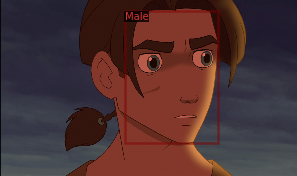

481.jpg


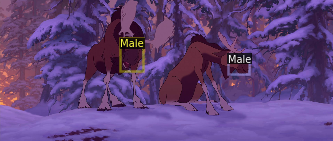

537.jpg


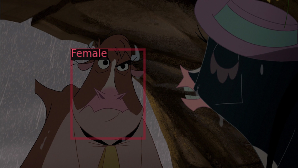

455.jpg


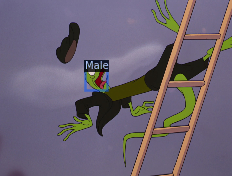

258.jpg


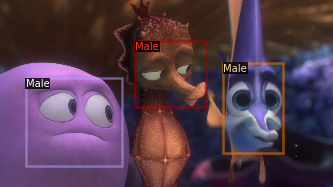

302.jpg


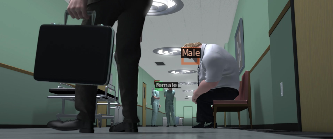

538.jpg


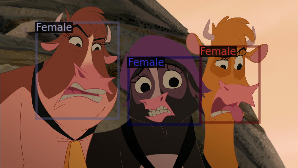

418.jpg


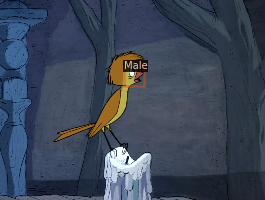

35.jpg


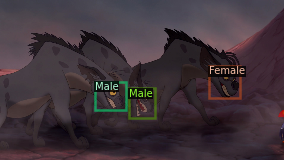

102.jpg


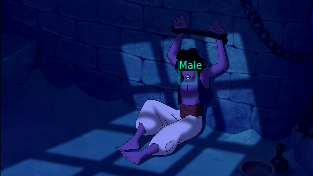

461.jpg


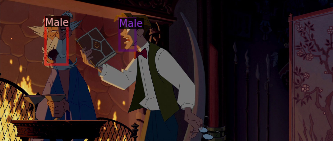

632.jpg


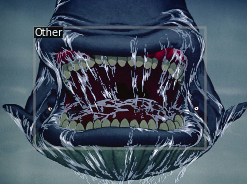

407.jpg


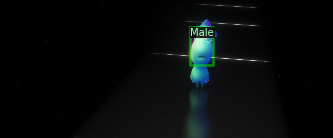

516.jpg


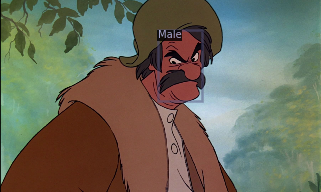

202.jpg


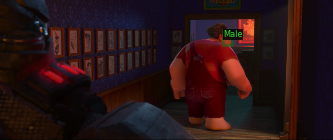

190.jpg


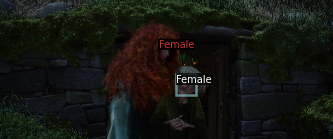

In [ ]:
# Visualize the dataset with annotations
from detectron2.data import detection_utils as utils
from detectron2.data import build_detection_train_loader

def output(vis, fname):
    print(fname)
    cv2_imshow(vis.get_image()[:, :, ::-1])

scale = 0.25
data_loader = build_detection_train_loader(cfg)
gender_metadata = MetadataCatalog.get(test_name) # set catalog, e.g. "cartoon_val"

for batch in data_loader:
  for per_image in batch:
    # Pytorch tensor is in (C, H, W) format
    img = per_image["image"].permute(1, 2, 0).cpu().detach().numpy()
    img = utils.convert_image_to_rgb(img, cfg.INPUT.FORMAT)
    
    visualizer = Visualizer(img, metadata=gender_metadata, scale=scale)
    target_fields = per_image["instances"].get_fields()
    labels = [gender_metadata.thing_classes[i] for i in target_fields["gt_classes"]]
    vis = visualizer.overlay_instances(
        labels=labels,
        boxes=target_fields.get("gt_boxes", None),
        masks=target_fields.get("gt_masks", None),
        keypoints=target_fields.get("gt_keypoints", None),
    )
    output(vis, str(per_image["image_id"]) + ".jpg")
  break

[08/09 12:10:38 d2.data.build]: Removed 0 images with no usable annotations. 650 images left.


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{'file_name': './Detection_Test/beauty-and-the-beast-disneyscreencaps.com-4765.jpg', 'height': 1080, 'width': 1920, 'image_id': 97, 'annotations': [{'iscrowd': 0, 'bbox': [968, 132, 275, 365], 'category_id': 1, 'attributes': {'animation_style': '2_d', 'character_style': 'machine', 'gender': 'male'}, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}


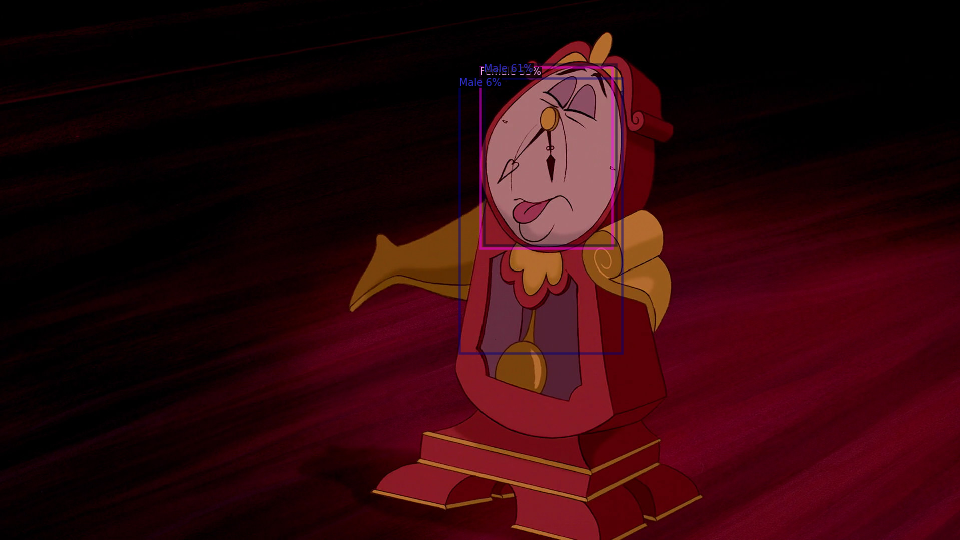

{'file_name': './Detection_Test/incredibles-disneyscreencaps.com-2433.jpg', 'height': 802, 'width': 1920, 'image_id': 299, 'annotations': [{'iscrowd': 0, 'bbox': [1106, 100, 287, 422], 'category_id': 1, 'attributes': {'animation_style': '3_d', 'character_style': 'human', 'gender': 'male'}, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}


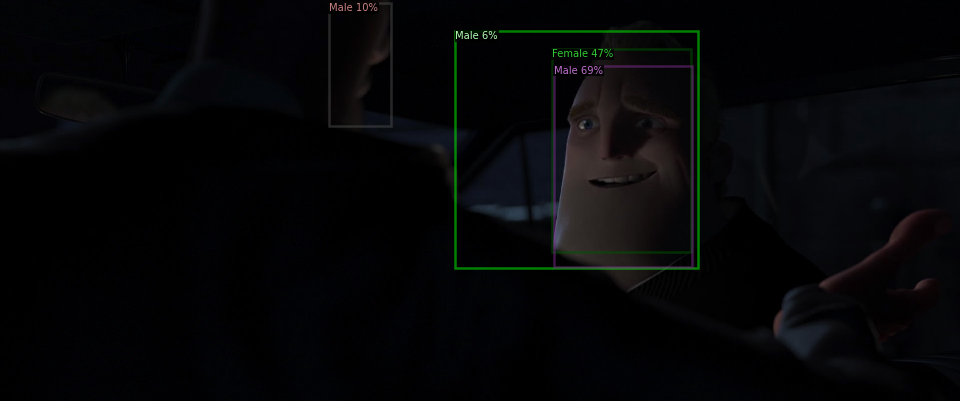

{'file_name': './Detection_Test/hunchback-of-the-notre-dame-disneyscreencaps.com-7419.jpg', 'height': 1080, 'width': 1920, 'image_id': 549, 'annotations': [{'iscrowd': 0, 'bbox': [858, 417, 363, 339], 'category_id': 1, 'attributes': {'animation_style': '2_d', 'character_style': 'human', 'gender': 'male'}, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}


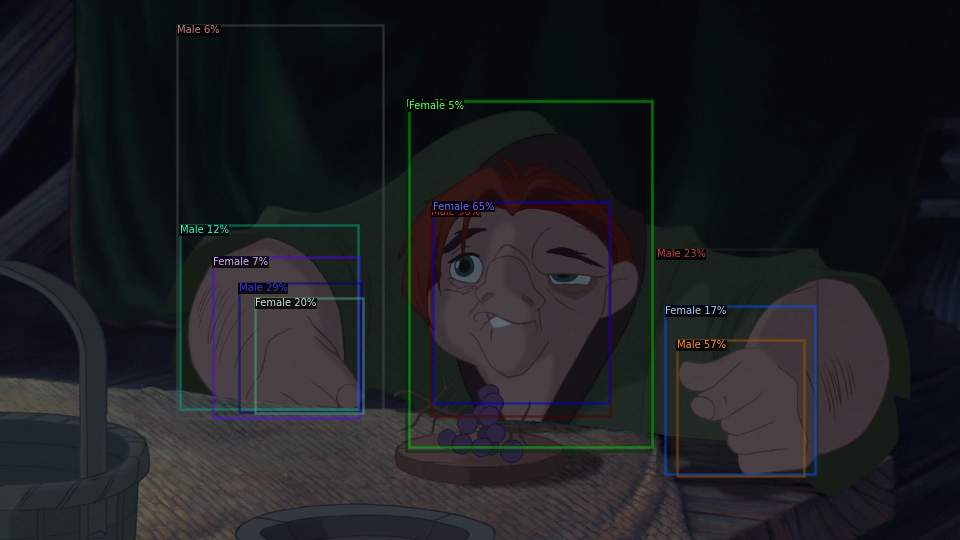

In [ ]:
# Visualize some predictions
from detectron2.utils.visualizer import ColorMode
dataset_dicts = detectron2.data.get_detection_dataset_dicts(test_name) # set dicts name
gender_metadata = MetadataCatalog.get(test_name) # set catalog name

for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    print(d)
    v = Visualizer(im[:, :, ::-1],
                   metadata=gender_metadata, 
                   scale=0.5, 
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
# Evaluate the model on the full test set
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator(test_name, cfg, False, output_dir="./out/") # set test name, usually either "cartoon_val" or "disney_test_set"
test_loader = build_detection_test_loader(cfg, test_name) # set test name, usually either "cartoon_val" or "disney_test_set"
inference_on_dataset(predictor.model, test_loader, evaluator)

WARNING [08/09 12:10:59 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[08/09 12:10:59 d2.evaluation.coco_evaluation]: Trying to convert 'Detection_Test' to COCO format ...
[08/09 12:10:59 d2.data.datasets.coco]: Converting annotations of dataset 'Detection_Test' to COCO format ...)
[08/09 12:10:59 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[08/09 12:10:59 d2.data.datasets.coco]: Conversion finished, #images: 650, #annotations: 1388
[08/09 12:10:59 d2.data.datasets.coco]: Caching COCO format annotations at './out/Detection_Test_coco_format.json' ...
[08/09 12:10:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/09 12:10:59 d2.data.common]: Serializing 650 elements to byte tensors and concatenating them all ...
[08/09 12:10:59 d2.data.common]: Seria

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[08/09 12:11:01 d2.evaluation.evaluator]: Inference done 11/650. Dataloading: 0.0059 s/iter. Inference: 0.1117 s/iter. Eval: 0.0003 s/iter. Total: 0.1179 s/iter. ETA=0:01:15
[08/09 12:11:06 d2.evaluation.evaluator]: Inference done 54/650. Dataloading: 0.0062 s/iter. Inference: 0.1099 s/iter. Eval: 0.0003 s/iter. Total: 0.1165 s/iter. ETA=0:01:09
[08/09 12:11:11 d2.evaluation.evaluator]: Inference done 98/650. Dataloading: 0.0059 s/iter. Inference: 0.1092 s/iter. Eval: 0.0003 s/iter. Total: 0.1157 s/iter. ETA=0:01:03
[08/09 12:11:16 d2.evaluation.evaluator]: Inference done 143/650. Dataloading: 0.0061 s/iter. Inference: 0.1080 s/iter. Eval: 0.0003 s/iter. Total: 0.1146 s/iter. ETA=0:00:58
[08/09 12:11:21 d2.evaluation.evaluator]: Inference done 190/650. Dataloading: 0.0057 s/iter. Inference: 0.1065 s/iter. Eval: 0.0003 s/iter. Total: 0.1127 s/iter. ETA=0:00:51
[08/09 12:11:26 d2.evaluation.evaluator]: Inference done 237/650. Dataloading: 0.0057 s/iter. Inference: 0.1054 s/iter. Eval: 0.

OrderedDict([('bbox',
              {'AP': 14.860494334169122,
               'AP-Female': 26.37393129014263,
               'AP-Male': 18.20755171236474,
               'AP-Other': 0.0,
               'AP50': 27.99040549461107,
               'AP75': 13.924737628124017,
               'APl': 17.80151625666014,
               'APm': 9.361736736158276,
               'APs': 4.931673427315173})])

In [ ]:
# Optionally save out file
!zip -r /content/drive/MyDrive/machine_learning/Results/disney3Dhumantest_detection_inference_resnet101_threshold0.05.zip out > /dev/null

In [ ]:
# a model with high precision punishes misclassifications (fewer FPs, more FNs)
# a model with high recall punishes misdetections (fewer FNs, more FPs)
# lowering the threshold improves the mAP but that doesn't necessarily make it a better model
# because the misclassifications (FPs) and duplicate detections clutter the image so much
# hard to decide when the FPs become intolerable, so good to stick to default threshold of 0.7 (or higher depending on the model)

## Evaluate dataset without annotations (Eye-Ball It)
Usually the model is evaluated following the COCO Standards of evaluation. Mean Average Precision (mAP) is used to evaluate the performance of the model.

In [ ]:
# !unzip /content/drive/MyDrive/machine_learning/datasets/disney_test_set.zip > /dev/null
# !unzip /content/drive/MyDrive/machine_learning/datasets/disney_test_3D.zip > /dev/null
# %mkdir out/

In [ ]:
# Inference should use the config with parameters that are used in training
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("output/config.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 # set threshold for this model # 0.9 good for ResNet50, 0.7 good for ResNet101
cfg.MODEL.WEIGHTS = "output/model_final.pth"
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # "Face"
cfg.DATASETS.TRAIN = "inference"
predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


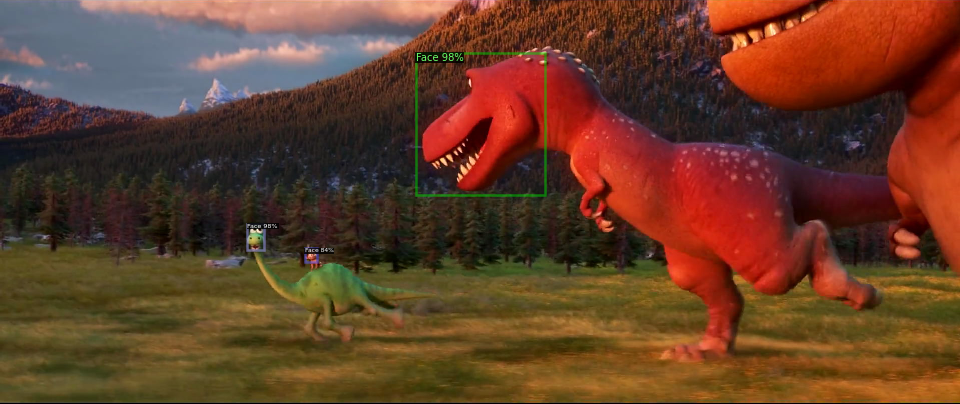

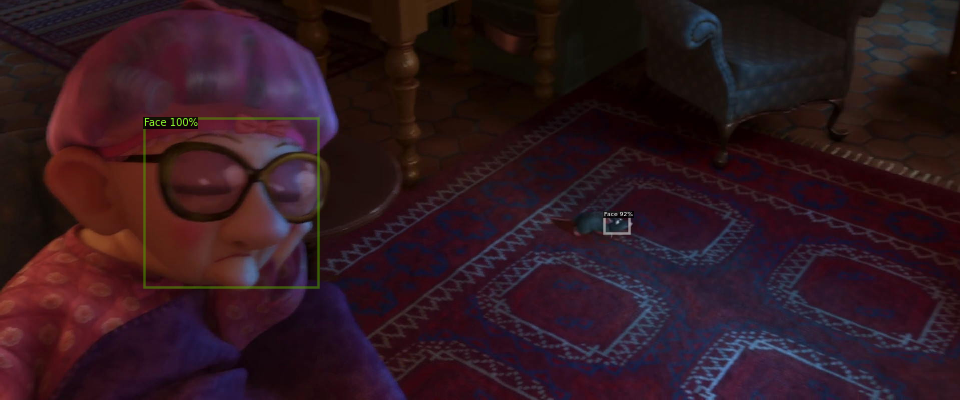

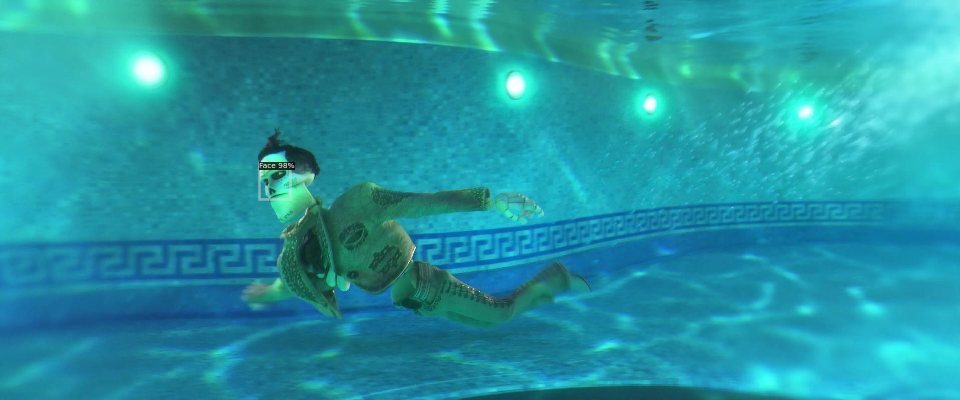

In [ ]:
# Randomly select several samples to visualize the prediction results.
from detectron2.utils.visualizer import ColorMode
import glob as gb

DATASET = "/content/3d_train"
metadata = MetadataCatalog.get("inference")
fnames = gb.glob(f"{DATASET}/*")

for d in random.sample(fnames, 3):   
    im = cv2.imread(d)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=metadata, 
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])
    #cv2.imwrite('out/'+d.split('/')[1],v.get_image()[:, :, ::-1])

In [ ]:
# Evaluate the model on the full dataset
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("inference", cfg, False, output_dir="./out/")
test_loader = build_detection_test_loader(cfg, "inference")
inference_on_dataset(predictor.model, test_loader, evaluator)
# commandline output is meaningless, we are interested in file "" in out/

In [ ]:
# Zip
# !zip -r out.zip out > /dev/null

## Misc

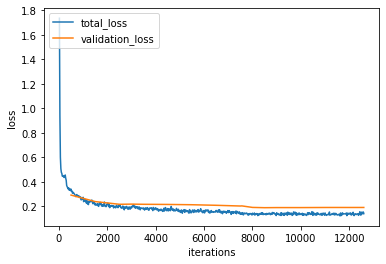

In [ ]:
# Visualize loss
import json
import matplotlib.pyplot as plt

experiment_folder = './output'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

plt.plot(
    [x['iteration'] for x in experiment_metrics if 'total_loss' in x], 
    [x['total_loss'] for x in experiment_metrics if 'total_loss' in x]
    )

plt.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x]
    )

plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend(['total_loss', 'validation_loss'], loc='upper left')
plt.savefig('./output/loss.png')
plt.show()

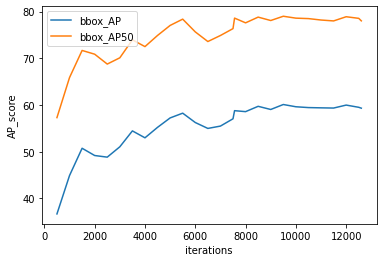

In [ ]:
# Visualize bbox AP
import json
import matplotlib.pyplot as plt

experiment_folder = './output'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

plt.plot(
    [x['iteration'] for x in experiment_metrics if 'bbox/AP' in x], 
    [x['bbox/AP'] for x in experiment_metrics if 'bbox/AP50' in x]
    )

plt.plot(
    [x['iteration'] for x in experiment_metrics if 'bbox/AP' in x], 
    [x['bbox/AP50'] for x in experiment_metrics if 'bbox/AP50' in x]
    )

plt.xlabel("iterations")
plt.ylabel("AP_score")
plt.legend(['bbox_AP', 'bbox_AP50'], loc='upper left')
plt.savefig('./output/AP.png')
plt.show()

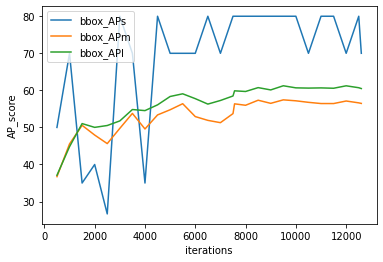

In [ ]:
# Visulize bbox AP by bbox size
import json
import matplotlib.pyplot as plt

experiment_folder = './output'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

plt.plot(
    [x['iteration'] for x in experiment_metrics if 'bbox/AP' in x], 
    [x['bbox/APs'] for x in experiment_metrics if 'bbox/APs' in x]
    )

plt.plot(
    [x['iteration'] for x in experiment_metrics if 'bbox/AP' in x], 
    [x['bbox/APm'] for x in experiment_metrics if 'bbox/APm' in x]
    )

plt.plot(
    [x['iteration'] for x in experiment_metrics if 'bbox/AP' in x], 
    [x['bbox/APl'] for x in experiment_metrics if 'bbox/APl' in x]
    )

plt.xlabel("iterations")
plt.ylabel("AP_score")
plt.legend(['bbox_APs', 'bbox_APm', 'bbox_APl'], loc='upper left')
plt.savefig('./output/AP_bbox_size.png')
plt.show()

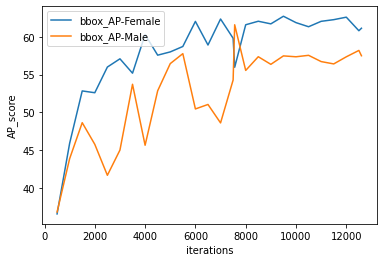

In [ ]:
# Visualize gender
import json
import matplotlib.pyplot as plt

experiment_folder = './output'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

plt.plot(
    [x['iteration'] for x in experiment_metrics if 'bbox/AP' in x], 
    [x['bbox/AP-Female'] for x in experiment_metrics if 'bbox/AP-Female' in x]
    )

plt.plot(
    [x['iteration'] for x in experiment_metrics if 'bbox/AP' in x], 
    [x['bbox/AP-Male'] for x in experiment_metrics if 'bbox/AP-Male' in x]
    )

# plt.plot(
#     [x['iteration'] for x in experiment_metrics if 'bbox/AP' in x], 
#     [x['bbox/AP-Other'] for x in experiment_metrics if 'bbox/AP-Other' in x]
#     )

plt.xlabel("iterations")
plt.ylabel("AP_score")
plt.legend(['bbox_AP-Female', 'bbox_AP-Male', 'bbox_AP-Other'], loc='upper left')
plt.savefig('./output/AP_bbox_gender.png')
plt.show()

In [ ]:
# Combine
dir = "./3d_test_files"

json_file = f"{dir}/instances.json"
with open(json_file) as f:
  instances = json.load(f)

json_file = f"{dir}/coco_instances_results.json"
with open(json_file) as f:
  predictions = json.load(f)

for instance in instances:
  id = instance["image_id"]
  for prediction in predictions:
    if prediction["image_id"] == id:
      bbox = [int(x) for x in prediction["bbox"]]
      instance["annotations"].append({"bbox": bbox, "category_id": 0})
      predictions.remove(prediction) # so that same prediction doesn't get added multiple times


# save to file
import json

jsonString = json.dumps(instances)
jsonFile = open(f"{dir}/instances_new.json", "w")
jsonFile.write(jsonString)
jsonFile.close()

In [ ]:
# Optionally visualize and save all predictions to a folder
from detectron2.utils.visualizer import ColorMode

import glob as gb
fnames = gb.glob(f"{test_name}/*.jpg")

for d in fnames:
    try:    
      im = cv2.imread(d)
      outputs = predictor(im)
      v = Visualizer(im[:, :, ::-1],
                    metadata=gender_metadata, 
                    scale=0.8,
                    instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels
      )
      v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
      #cv2_imshow(v.get_image()[:, :, ::-1])
      cv2.imwrite(f"out/{d.split('/')[1]}",v.get_image()[:, :, ::-1])
    except:
      print(f"Problem predicting file: {d}")

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


In [ ]:
# Alternative way to show ground-truth bboxes

# Dettrain
path = "CartoonDataset/val"
dataset_dicts = get_board_dicts(path)
board_metadata = MetadataCatalog.get("cartoon_val")

# Disney 3D Human Test
# path = "disney_3D_human_test"
# dataset_dicts = get_board_dicts(path)
# board_metadata = MetadataCatalog.get("disney_test_set")

# Other datasets
#path = "icartoonface_rectrain/annotations"
#dataset_dicts = get_board_dicts(path, "val", 100)
#board_metadata = MetadataCatalog.get("cartoon_val")

#path = "disney_2000-present/annotations" 
#dataset_dicts = get_board_dicts(path, "val")
#board_metadata = MetadataCatalog.get("cartoon_val")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    print(d)
    visualizer = Visualizer(img[:, :, ::-1], metadata=board_metadata, scale=0.25,)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
# Alternative way to visualize some predictions
from detectron2.utils.visualizer import ColorMode

# Dettrain
path = "CartoonDataset/val" 
dataset_dicts = get_board_dicts(path)
board_metadata = MetadataCatalog.get("cartoon_val")

# Disney 3D Human Test
# path = "disney_3D_human_test"
# dataset_dicts = get_board_dicts(path)
# board_metadata = MetadataCatalog.get("disney_test_set")

for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(d)
    v = Visualizer(im[:, :, ::-1],
                   metadata=board_metadata, 
                   scale=0.25,
                   #instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])